In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
Pop = pd.read_csv("/content/Tomates+météo - Tableau 1 (1).csv")
Pop

,Date,prix moyen au kg,prix minimal,prix maximal,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
0,21/06/21,1.50,1.5,1.5,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm
1,04/12/20,1.50,NaN,NaN,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm
2,06/11/20,1.10,NaN,NaN,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm
3,05/11/20,1.10,NaN,NaN,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm
4,30/10/20,1.05,1.0,1.1,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.1,1.1,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm
420,20/06/13,1.50,1.5,1.5,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm
421,17/06/13,1.50,1.5,1.5,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm
422,18/09/12,1.10,1.1,1.1,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm


In [ ]:
Pop = Pop.drop(["prix maximal","prix minimal"], axis=1)
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm


In [ ]:
Pop.describe()

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
count,421.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,1.264798,0.464830,12.051651,23.908726,1.475236,436.160377,40.075472
std,0.288990,0.776784,3.965298,5.803186,4.417398,266.967955,12.427627
min,0.500000,0.016000,-0.100000,6.600000,0.000000,0.000000,14.400000
25%,1.050000,0.100000,9.800000,20.100000,0.000000,210.000000,31.500000
50%,1.200000,0.240000,12.300000,23.700000,0.000000,447.500000,38.900000
75%,1.500000,0.500000,14.700000,28.000000,0.400000,658.500000,46.800000
max,2.000000,7.680000,23.200000,41.300000,31.900000,906.000000,92.600000


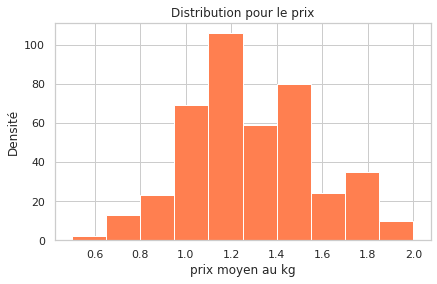

skew= 0.22827047693351454


In [ ]:
plt.hist(Pop['prix moyen au kg'],color ='coral')
plt.title('Distribution pour le prix')
plt.xlabel('prix moyen au kg')
plt.ylabel('Densité')
plt.show()
print ("skew=", Pop['prix moyen au kg'].skew())

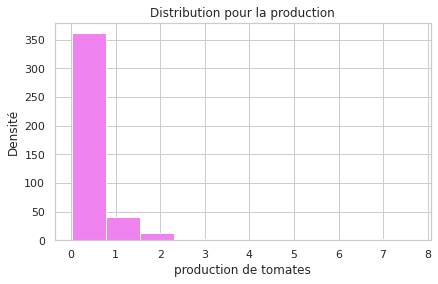

skew= 5.583569472053098


In [ ]:
plt.hist(Pop['Production quantité \ntonne(s)'],color ='violet')
plt.title('Distribution pour la production')
plt.xlabel('production de tomates')
plt.ylabel('Densité')
plt.show()
print ("skew=", Pop['Production quantité \ntonne(s)'].skew())

In [ ]:
Pop['catégorie tomates'].value_counts().to_frame()

,catégorie tomates
Tomate ronde cat.I 57-67mm,372
Tomate ronde cat.I 67-82mm,52


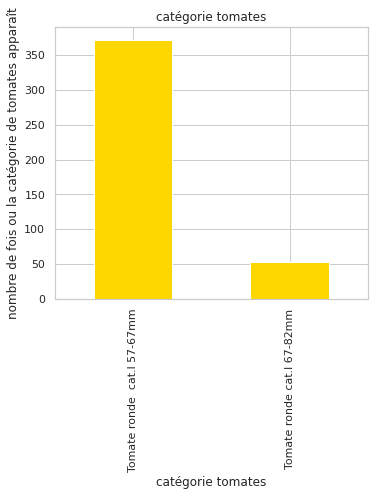

In [ ]:
Pop['catégorie tomates'].value_counts().plot(kind='bar',figsize=(5,5),title= 'catégorie tomates',color ='gold')
plt.xlabel('catégorie tomates')
plt.ylabel("nombre de fois ou la catégorie de tomates apparaît")
plt.show()

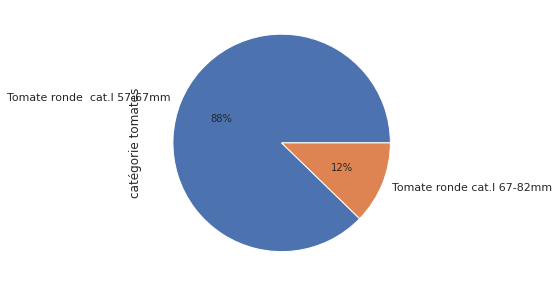

In [ ]:
Pop['catégorie tomates'].value_counts().plot(kind='pie', figsize=[5,5],
          autopct=lambda p: '{:.0f}%'.format(p,(p/100)*Pop['catégorie tomates'].value_counts().sum()))

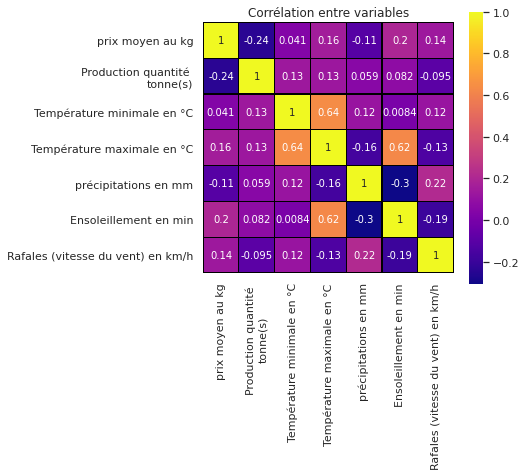

In [ ]:
Corr = Pop.corr()


f, ax = plt.subplots(figsize=(5,5))
plt.title('Corrélation entre variables')


sns.heatmap(Corr,linewidths=0.25,vmax=1.0, square=True, cmap="plasma", linecolor='black', annot=True)
plt.show()

In [ ]:
Pop =  Pop.interpolate() #pour remplacer les valeurs nulles par une valeur moyenne
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm


In [ ]:
dummy_tomate1 = pd.get_dummies(Pop['catégorie tomates'])
dummy_tomate1

,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
419,0,1
420,0,1
421,0,1
422,0,1


In [ ]:
T =  pd.merge(
    left=Pop,
    right=dummy_tomate1,
    left_index=True,
    right_index=True,
)

T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,Tomate ronde cat.I 57-67mm,1,0
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,Tomate ronde cat.I 57-67mm,1,0
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,Tomate ronde cat.I 57-67mm,1,0
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,Tomate ronde cat.I 57-67mm,1,0
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,Tomate ronde cat.I 57-67mm,1,0
...,...,...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,Tomate ronde cat.I 67-82mm,0,1
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,Tomate ronde cat.I 67-82mm,0,1
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,Tomate ronde cat.I 67-82mm,0,1
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,Tomate ronde cat.I 67-82mm,0,1


In [ ]:
T = T.drop(["catégorie tomates"], axis=1)
T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2,1,0
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9,1,0
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8,1,0
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4,1,0
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7,1,0
...,...,...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6,0,1
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1,0,1
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1,0,1
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2,0,1


In [ ]:
T['Date'] = pd.to_datetime(T['Date'])
T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
0,2021-06-21,1.50,0.200,15.7,24.9,3.8,423,61.2,1,0
1,2020-04-12,1.50,0.100,2.9,6.6,0.8,256,65.9,1,0
2,2020-06-11,1.10,0.100,2.3,13.4,0.0,491,46.8,1,0
3,2020-05-11,1.10,0.100,1.8,11.5,0.0,533,32.4,1,0
4,2020-10-30,1.05,0.100,12.6,15.9,0.0,0,40.7,1,0
...,...,...,...,...,...,...,...,...,...,...
419,2013-06-24,1.10,1.120,10.5,19.1,0.0,342,42.6,0,1
420,2013-06-20,1.50,0.075,14.0,21.5,0.8,216,37.1,0,1
421,2013-06-17,1.50,0.020,15.0,27.2,6.8,210,61.1,0,1
422,2012-09-18,1.10,0.180,10.3,20.1,0.0,126,34.2,0,1


In [ ]:
T['mois'] = T['Date'].dt.month
T['jour'] = T['Date'].dt.day
T['année'] = T['Date'].dt.year

In [ ]:
T = T.drop(["Date"], axis=1)
T

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm,mois,jour,année
0,1.50,0.200,15.7,24.9,3.8,423,61.2,1,0,6,21,2021
1,1.50,0.100,2.9,6.6,0.8,256,65.9,1,0,4,12,2020
2,1.10,0.100,2.3,13.4,0.0,491,46.8,1,0,6,11,2020
3,1.10,0.100,1.8,11.5,0.0,533,32.4,1,0,5,11,2020
4,1.05,0.100,12.6,15.9,0.0,0,40.7,1,0,10,30,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1.10,1.120,10.5,19.1,0.0,342,42.6,0,1,6,24,2013
420,1.50,0.075,14.0,21.5,0.8,216,37.1,0,1,6,20,2013
421,1.50,0.020,15.0,27.2,6.8,210,61.1,0,1,6,17,2013
422,1.10,0.180,10.3,20.1,0.0,126,34.2,0,1,9,18,2012


In [ ]:
dummy_mois = pd.get_dummies(T['mois'])
dummy_jour = pd.get_dummies(T['jour'])
dummy_a = pd.get_dummies(T['année'])

In [ ]:

T1 = pd.merge(
    left=T,
    right=dummy_mois,
    left_index=True,
    right_index=True,
)

T2 = pd.merge(
    left=T1,
    right=dummy_a,
    left_index=True,
    right_index=True,
)

T3 = pd.merge(
    left=T2,
    right=dummy_jour,
    left_index=True,
    right_index=True,
)

In [ ]:
T3 = T3.drop(["mois","jour","année"], axis=1)
T3

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm,1,2,3,4,5,6_x,7_x,8_x,9_x,10_x,11_x,12_x,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,1.50,0.200,15.7,24.9,3.8,423,61.2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1.50,0.100,2.9,6.6,0.8,256,65.9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.10,0.100,2.3,13.4,0.0,491,46.8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.10,0.100,1.8,11.5,0.0,533,32.4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.05,0.100,12.6,15.9,0.0,0,40.7,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1.10,1.120,10.5,19.1,0.0,342,42.6,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
420,1.50,0.075,14.0,21.5,0.8,216,37.1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
421,1.50,0.020,15.0,27.2,6.8,210,61.1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
422,1.10,0.180,10.3,20.1,0.0,126,34.2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Prix = T3['prix moyen au kg'] 
Production = T3['Production quantité \ntonne(s)']

**Modélisation**

In [ ]:
#pour le prix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X =  T3.drop(['prix moyen au kg'], axis=1)
y = Prix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)
model.score(X_test, y_test)

0.49528312007470304

In [ ]:
model.score(X_train, y_train)

0.7365878088084561

In [ ]:
y_tr = model.predict(X_train)
y_pred = model.predict(X_test)

In [ ]:
from math import sqrt
rmseP1T1LR =sqrt(mean_squared_error(y_test, y_pred))
print(rmseP1T1LR)

0.21442669666197026


In [ ]:
sqrt(mean_squared_error(y_train, y_tr))

0.14455669244159386

In [ ]:
mean_absolute_error(y_train, y_tr)

0.10686926333409558

In [ ]:
mean_absolute_error(y_test, y_pred)

0.16759722044517322

In [ ]:
print(r2_score(y_test, y_pred))
print(r2_score(y_train, y_tr))

0.495283120074703
0.7365878088084561


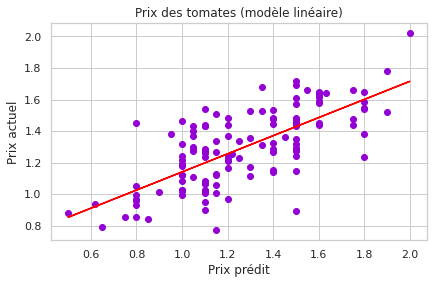

In [ ]:
plt.scatter(y_test, y_pred, color = 'darkviolet')
plt.title('Prix des tomates (modèle linéaire)')
plt.xlabel('Prix prédit')
plt.ylabel('Prix actuel')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv = 5)

print (scores, np.mean(scores), np.std(scores))


[0.53186046 0.58813349 0.61304475 0.72007859 0.54723216] 0.6000698892167429 0.06656915929687521


In [ ]:
from sklearn.model_selection import cross_val_predict
predictionsp1t = cross_val_predict(model, X_test, y_test, cv = 5) 

In [ ]:
sqrt(mean_squared_error(y_test, predictionsp1t))

0.24763663696627627

In [ ]:
predictionsp1T = cross_val_predict(model, X_train, y_train, cv = 5) 
sqrt(mean_squared_error(y_train, predictionsp1T))

0.17704552558684258

In [ ]:
mean_absolute_error(y_train, predictionsp1T)

0.13197206301309533

In [ ]:
mean_absolute_error(y_test, predictionsp1t)

0.19001264362110631

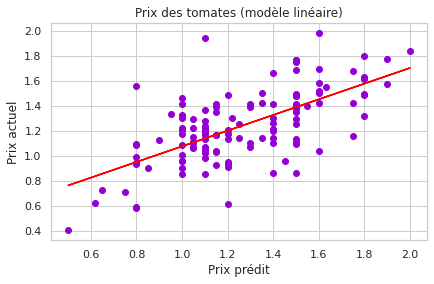

In [ ]:
plt.scatter(y_test, predictionsp1t, color = 'darkviolet')
plt.title('Prix des tomates (modèle linéaire)')
plt.xlabel('Prix prédit')
plt.ylabel('Prix actuel')
z = np.polyfit(y_test, predictionsp1t, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')
plt.show()

In [ ]:
#Pour la production

from sklearn.model_selection import train_test_split

X2 =  T3.drop("Production quantité \ntonne(s)", axis=1)
y2 = Production

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [ ]:
model = lr.fit(X_train, y_train)
model.score(X_test, y_test)

0.16110962513705995

In [ ]:
model.score(X_train, y_train)

0.2719159968223276

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
sqrt(mean_squared_error(y_test, y_pred))

0.7873084005918595

In [ ]:
sqrt(mean_squared_error(y_train, y_tr))

1.1556463988421513

In [ ]:
mean_absolute_error(y_train, y_tr)

1.0029166098083762

In [ ]:
mean_absolute_error(y_test, y_pred)

0.4056291687070662

In [ ]:
print(r2_score(y_test, y_pred))
print(r2_score(y_train, y_tr))

0.16110962513705995
-1.462819384275189


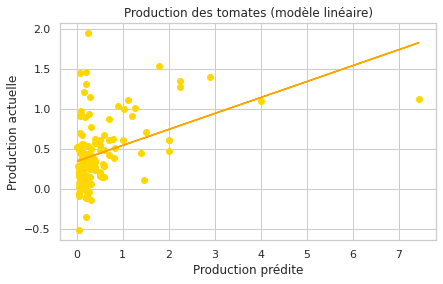

In [ ]:
plt.scatter(y_test, y_pred, color = 'gold')
plt.title('Production des tomates (modèle linéaire)')
plt.xlabel('Production prédite')
plt.ylabel('Production actuelle')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='orange')
plt.show()

In [ ]:
predictionsp2t = cross_val_predict(model, X_test, y_test, cv = 5) 
predictionsp2T = cross_val_predict(model, X_train, y_train, cv = 5) 

In [ ]:
sqrt(mean_squared_error(y_test, predictionsp2t))

0.9631587740868617

In [ ]:
sqrt(mean_squared_error(y_train, predictionsp2T))

0.793521096006748

In [ ]:
mean_absolute_error(y_train, predictionsp2T)

0.4313230395512034

In [ ]:
mean_absolute_error(y_test, predictionsp2t)

0.630499002239374

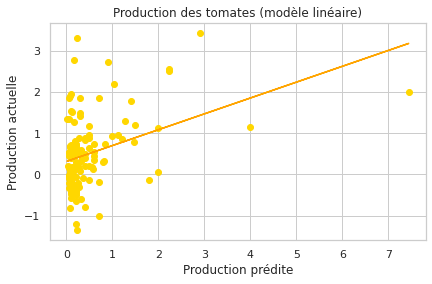

In [ ]:
plt.scatter(y_test, predictionsp2t, color = 'gold')
plt.title('Production des tomates (modèle linéaire)')
plt.xlabel('Production prédite')
plt.ylabel('Production actuelle')
z = np.polyfit(y_test, predictionsp2t, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='orange')
plt.show()